### models from https://github.com/qubvel/segmentation_models.pytorch

In [1]:
!wandb login 2a29d4ea12edef115a98307eee0e9bf7db67b635

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import ast
import copy
import gc
import glob
import json
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
import skimage
import torch
import wandb
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedGroupKFold
from torch.optim import lr_scheduler
from tqdm import tqdm

from src.dataset_utils import Dataset, create_transform
from src.train_utils import dice_score, iou_score, seed_everything, train

InteractiveShell.ast_node_interactivity = "all"

In [3]:
wandb.init(dir="/app/_data/", project="tract_segmentation_main")

wandb: Currently logged in as: tatanko. Use `wandb login --relogin` to force relogin


## Train configuration

In [4]:
with open("/app/_data/base_config.json", "r") as f:
    CONFIG = json.load(f)

In [5]:
CONFIG

{'IMG_SIZE': [384, 384],
 'BATCH_SIZE': 18,
 'SEED': 38,
 'ENCODER': 'timm-efficientnet-b4',
 'ENCODER_WEIGHTS': 'noisy-student',
 'MODEL_PATH': '/app/_data/models/model1/',
 'MODEL_NAME': 'DeepLabV3Plus',
 'SEQUENCE': False,
 'N_CHANELS': 1,
 'MODEL_TYPE': 'one_input',
 'NORMALIZE': True,
 'FOLD': 1,
 'UINT8': False,
 'DEVICE': 'cuda',
 'LABELS': {'0': 'large_bowel', '1': 'small_bowel', '2': 'stomach'}}

In [6]:
CONFIG["IMG_SIZE"] = (512, 512)
CONFIG["FOLD"] = 5
CONFIG["SEED"] = 42
CONFIG["NORMALIZE"] = False
CONFIG["BATCH_SIZE"] = 20
CONFIG[
    "MODEL_PATH"
] = f"/app/_data/models/deeplab_fold_{CONFIG['FOLD']}_two_sided_512_seed_{CONFIG['SEED']}_seq_1/"
CONFIG["SEQUENCE"] = True

## Dataframe

In [7]:
df = pd.read_csv("/app/_data/folds.csv")

wrong1 = "case7_day0"
wrong2 = "case81_day30"
df = df[~df["id"].str.contains(wrong1) & ~df["id"].str.contains(wrong2)].reset_index(
    drop=True
)
gkf = StratifiedGroupKFold(n_splits=6, shuffle=True, random_state=38)
for n, (train_ixs, val_ix) in enumerate(
    gkf.split(
        X=df,
        y=df["is_mask"],
        groups=df["case"],
    )
):
    df.loc[val_ix, "fold"] = n
for fold in range(6):
    print(f"Proportion of images with mask and without in  fold #{int(fold)}")
    df[df["fold"] != fold][["is_mask"]].sum() / df[df["fold"] == fold][
        ["is_mask"]
    ].sum()

Proportion of images with mask and without in  fold #0


is_mask    4.38459
dtype: float64

Proportion of images with mask and without in  fold #1


is_mask    4.852732
dtype: float64

Proportion of images with mask and without in  fold #2


is_mask    5.653086
dtype: float64

Proportion of images with mask and without in  fold #3


is_mask    5.529295
dtype: float64

Proportion of images with mask and without in  fold #4


is_mask    5.699025
dtype: float64

Proportion of images with mask and without in  fold #5


is_mask    4.244197
dtype: float64

In [8]:
transform_func = create_transform(CONFIG["IMG_SIZE"])

In [9]:
col = "3Dnpy_512_bf"
df[col] = f"/app/_data/{col}/" + df["id"] + ".npy"

In [10]:
train_ds = Dataset(
    df=df[df["fold"] != CONFIG["FOLD"]],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col=col,
    norm=CONFIG["NORMALIZE"],
    shuffle=True,
    seed=CONFIG["SEED"],
    transform=transform_func,
    pad=False,
)
val_ds = Dataset(
    df=df[df["fold"] == CONFIG["FOLD"]],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col=col,
    norm=CONFIG["NORMALIZE"],
    shuffle=False,
    seed=CONFIG["SEED"],
    transform=None,
    pad=False,
)

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=True, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=CONFIG["BATCH_SIZE"] * 2, shuffle=False, num_workers=0
)

In [12]:
len(val_loader)

174

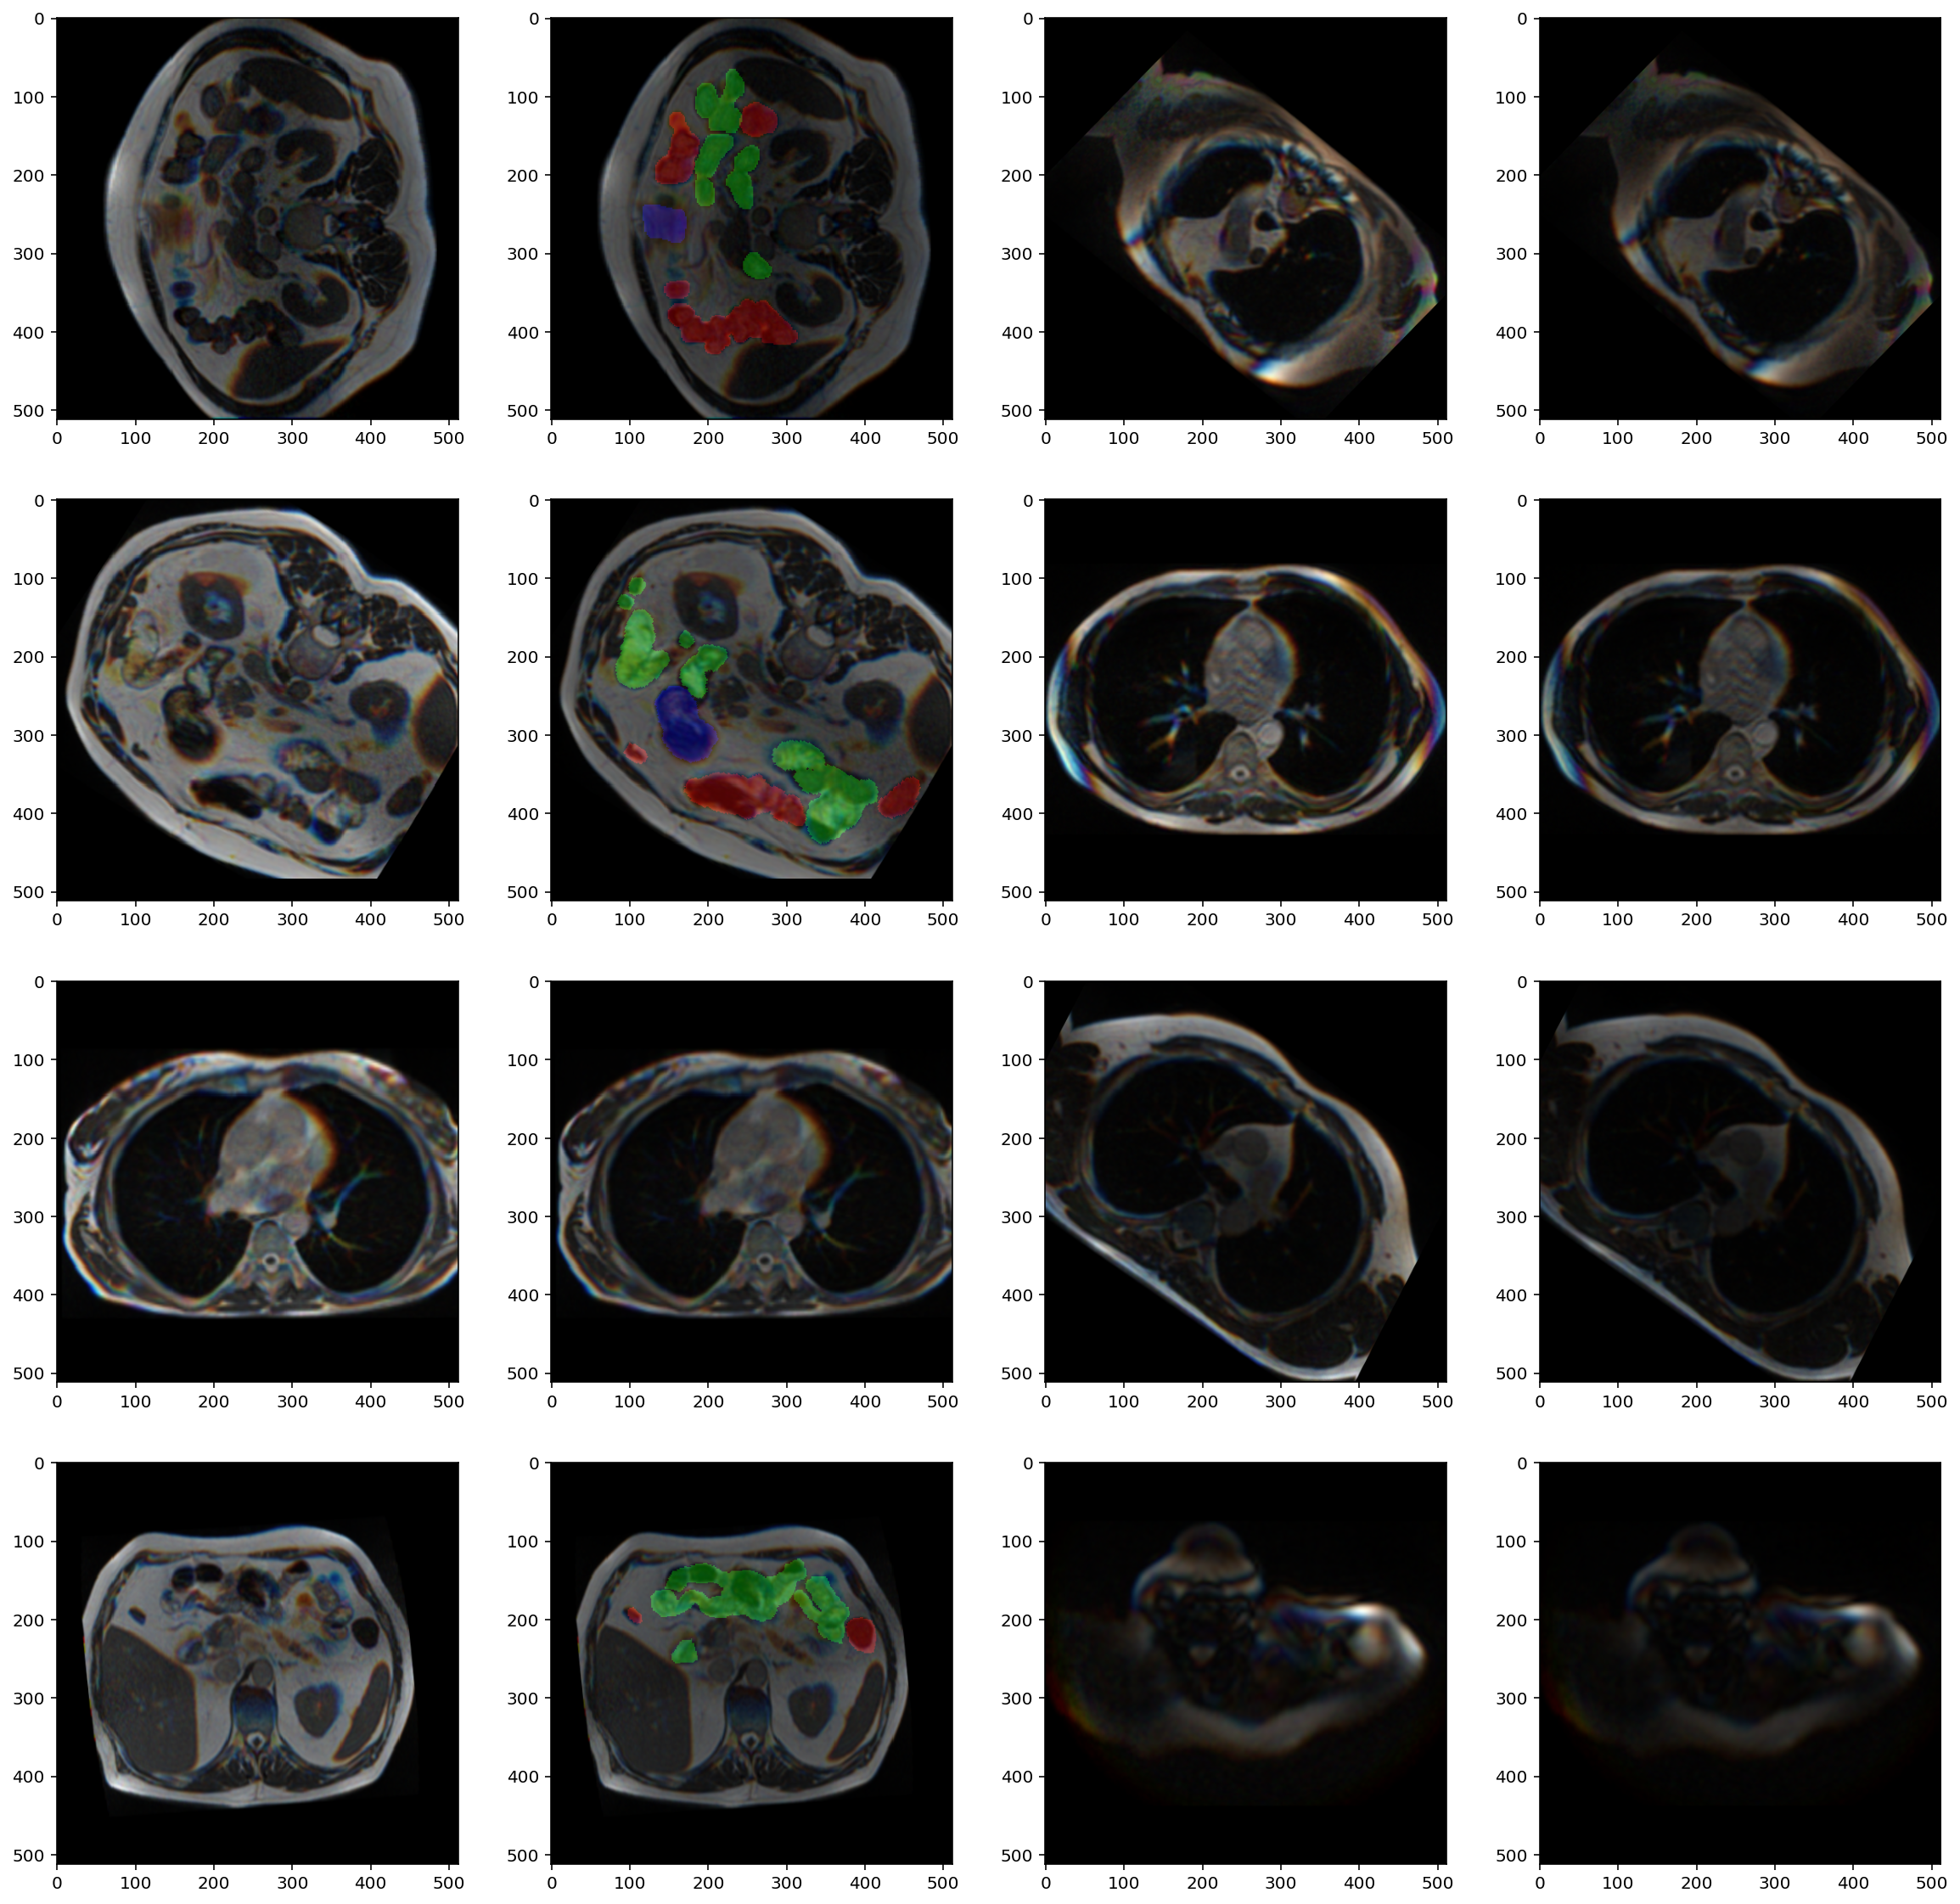

In [13]:
plt.figure(figsize=(20, 20))
for i in range(0, 16, 2):
    ix = np.random.randint(0, len(train_ds))
    img, mask = train_ds[ix]
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.subplot(4, 4, i + 2)
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis(mask, 0, 2), alpha=0.3)
plt.show();

## model

In [14]:
in_channels = 3
decoder_atrous_rates = (12, 24, 36)
decoder_channels = 256
encoder_output_stride = 16
encoder_depth = 5

CONFIG["MODEL_PARAMS"] = {
    "encoder_depth": encoder_depth,
    "decoder_atrous_rates": decoder_atrous_rates,
    "encoder_output_stride": encoder_output_stride,
    "decoder_channels": decoder_channels,
    "in_channels": in_channels,
}
if not os.path.exists(CONFIG["MODEL_PATH"]):
    os.mkdir(CONFIG["MODEL_PATH"])
with open(os.path.join(CONFIG["MODEL_PATH"], "config.json"), "w") as f:
    json.dump(CONFIG, f)

In [15]:
model = smp.DeepLabV3Plus(
    encoder_name=CONFIG["ENCODER"],
    encoder_depth=encoder_depth,
    encoder_weights=CONFIG["ENCODER_WEIGHTS"],
    encoder_output_stride=encoder_output_stride,
    decoder_channels=decoder_channels,
    decoder_atrous_rates=decoder_atrous_rates,
    in_channels=in_channels,
    classes=3,
    activation=None,
    upsampling=4,
    aux_params=None,
)
model = model.to(CONFIG["DEVICE"])

In [16]:
JaccardLoss = smp.losses.JaccardLoss(mode="multilabel", from_logits=True)
DiceLoss = smp.losses.DiceLoss(mode="multilabel", from_logits=True)
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss = smp.losses.LovaszLoss(mode="multilabel", per_image=True)
TverskyLoss = smp.losses.TverskyLoss(
    mode="multilabel", log_loss=False, from_logits=True, alpha=0.7, beta=0.3
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-6)

def loss_fn(y_pred, y_true):
    return DiceLoss(y_pred, y_true)

In [18]:
history, best_weights = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    n_epochs=50,
    config=CONFIG,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    loss_fn=loss_fn,
    wandb_log=True,
    early_stopping=5,
    lr_upd_coef=3,
)

Train: epoch #1: 100% 1564/1564 [57:48<00:00,  2.22s/it, current_dice=0.4655, epoch_dice=0.6243, gpu_memory=22.57 GB, lr=0.009938, train_loss=0.6215] 
Val:   epoch #1:   0% 0/174 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)
Val:   epoch #1: 100% 174/174 [06:52<00:00,  2.37s/it, current_dice=0.8750, current_iou=0.8750, epoch_dice=0.6885, epoch_hd=28.5480, epoch_iou=0.6466, gpu_memory=7.25 GB, val_loss=0.2639]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #2: 100% 1564/1564 [57:03<00:00,  2.19s/it, current_dice=0.5000, epoch_dice=0.7439, gpu_memory=22.73 GB, lr=0.009755, train_loss=0.4484] 
Val:   epoch #2: 100% 174/174 [06:54<00:00,  2.38s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.7686, epoch_hd=24.1711, epoch_iou=0.7289, gpu_memory=7.34 GB, val_loss=0.2430]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #3: 100% 1564/1564 [56:28<00:00,  2.17s/it, current_dice=0.8498, epoch_dice=0.8005, gpu_memory=22.75 GB, lr=0.009455, train_loss=0.3658] 
Val:   epoch #3: 100% 174/174 [06:30<00:00,  2.24s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8436, epoch_hd=21.5284, epoch_iou=0.8084, gpu_memory=7.35 GB, val_loss=0.1776]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #4: 100% 1564/1564 [56:25<00:00,  2.16s/it, current_dice=0.7775, epoch_dice=0.8236, gpu_memory=22.73 GB, lr=0.009045, train_loss=0.3316] 
Val:   epoch #4: 100% 174/174 [06:23<00:00,  2.20s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8601, epoch_hd=15.6438, epoch_iou=0.8257, gpu_memory=7.35 GB, val_loss=0.1756]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #5: 100% 1564/1564 [57:00<00:00,  2.19s/it, current_dice=0.8005, epoch_dice=0.8404, gpu_memory=22.73 GB, lr=0.008536, train_loss=0.3030]
Val:   epoch #5: 100% 174/174 [06:19<00:00,  2.18s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8664, epoch_hd=12.4726, epoch_iou=0.8333, gpu_memory=7.34 GB, val_loss=0.1975]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #6: 100% 1564/1564 [56:37<00:00,  2.17s/it, current_dice=0.9457, epoch_dice=0.8488, gpu_memory=22.75 GB, lr=0.007939, train_loss=0.2869] 
Val:   epoch #6: 100% 174/174 [06:37<00:00,  2.29s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8744, epoch_hd=15.7074, epoch_iou=0.8416, gpu_memory=7.35 GB, val_loss=0.1722]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #7: 100% 1564/1564 [57:16<00:00,  2.20s/it, current_dice=0.9398, epoch_dice=0.8554, gpu_memory=22.73 GB, lr=0.007270, train_loss=0.2790] 
Val:   epoch #7: 100% 174/174 [06:30<00:00,  2.24s/it, current_dice=0.9861, current_iou=0.9861, epoch_dice=0.8802, epoch_hd=14.9270, epoch_iou=0.8464, gpu_memory=7.34 GB, val_loss=0.1596]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #8: 100% 1564/1564 [57:02<00:00,  2.19s/it, current_dice=0.6283, epoch_dice=0.8670, gpu_memory=22.73 GB, lr=0.006545, train_loss=0.2592] 
Val:   epoch #8: 100% 174/174 [06:29<00:00,  2.24s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8948, epoch_hd=12.7397, epoch_iou=0.8630, gpu_memory=7.34 GB, val_loss=0.1456]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #9: 100% 1564/1564 [56:26<00:00,  2.17s/it, current_dice=0.4167, epoch_dice=0.8747, gpu_memory=22.73 GB, lr=0.005783, train_loss=0.2453] 
Val:   epoch #9: 100% 174/174 [06:28<00:00,  2.23s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9004, epoch_hd=13.7407, epoch_iou=0.8702, gpu_memory=7.36 GB, val_loss=0.1446]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #10: 100% 1564/1564 [56:56<00:00,  2.18s/it, current_dice=0.9763, epoch_dice=0.8801, gpu_memory=22.75 GB, lr=0.005001, train_loss=0.2355] 
Val:   epoch #10: 100% 174/174 [06:27<00:00,  2.23s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9030, epoch_hd=10.7664, epoch_iou=0.8730, gpu_memory=7.35 GB, val_loss=0.1327]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #11: 100% 1564/1564 [57:01<00:00,  2.19s/it, current_dice=0.6868, epoch_dice=0.8849, gpu_memory=22.77 GB, lr=0.004218, train_loss=0.2259] 
Val:   epoch #11: 100% 174/174 [06:27<00:00,  2.23s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9026, epoch_hd=10.3617, epoch_iou=0.8724, gpu_memory=7.37 GB, val_loss=0.1315]


Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #12: 100% 1564/1564 [56:54<00:00,  2.18s/it, current_dice=0.3333, epoch_dice=0.8892, gpu_memory=22.77 GB, lr=0.003456, train_loss=0.2187] 
Val:   epoch #12: 100% 174/174 [06:25<00:00,  2.22s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9096, epoch_hd=10.2933, epoch_iou=0.8798, gpu_memory=7.37 GB, val_loss=0.1261]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #13: 100% 1564/1564 [56:48<00:00,  2.18s/it, current_dice=0.9627, epoch_dice=0.8945, gpu_memory=22.77 GB, lr=0.002731, train_loss=0.2096] 
Val:   epoch #13: 100% 174/174 [06:16<00:00,  2.16s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9099, epoch_hd=10.6414, epoch_iou=0.8805, gpu_memory=7.37 GB, val_loss=0.1266]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #14: 100% 1564/1564 [56:34<00:00,  2.17s/it, current_dice=0.9794, epoch_dice=0.8998, gpu_memory=22.79 GB, lr=0.002062, train_loss=0.2000] 
Val:   epoch #14: 100% 174/174 [06:19<00:00,  2.18s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9135, epoch_hd=10.3139, epoch_iou=0.8844, gpu_memory=7.37 GB, val_loss=0.1273]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #15: 100% 1564/1564 [56:49<00:00,  2.18s/it, current_dice=0.8286, epoch_dice=0.9034, gpu_memory=22.77 GB, lr=0.001465, train_loss=0.1934] 
Val:   epoch #15: 100% 174/174 [06:25<00:00,  2.21s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9174, epoch_hd=9.3899, epoch_iou=0.8889, gpu_memory=7.37 GB, val_loss=0.1261] 


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #16: 100% 1564/1564 [56:26<00:00,  2.17s/it, current_dice=0.9486, epoch_dice=0.9069, gpu_memory=22.79 GB, lr=0.000956, train_loss=0.1890] 
Val:   epoch #16: 100% 174/174 [06:27<00:00,  2.23s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9178, epoch_hd=9.9389, epoch_iou=0.8893, gpu_memory=7.37 GB, val_loss=0.1243] 


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #17: 100% 1564/1564 [56:39<00:00,  2.17s/it, current_dice=0.8557, epoch_dice=0.9090, gpu_memory=22.77 GB, lr=0.000546, train_loss=0.1830] 
Val:   epoch #17: 100% 174/174 [06:28<00:00,  2.23s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9185, epoch_hd=8.9074, epoch_iou=0.8900, gpu_memory=7.37 GB, val_loss=0.1234]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #18: 100% 1564/1564 [56:39<00:00,  2.17s/it, current_dice=0.9004, epoch_dice=0.9104, gpu_memory=22.77 GB, lr=0.000246, train_loss=0.1815] 
Val:   epoch #18: 100% 174/174 [06:30<00:00,  2.24s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9179, epoch_hd=9.0329, epoch_iou=0.8893, gpu_memory=7.37 GB, val_loss=0.1241]


Train: epoch #19: 100% 1564/1564 [56:44<00:00,  2.18s/it, current_dice=0.9702, epoch_dice=0.9115, gpu_memory=22.77 GB, lr=0.000063, train_loss=0.1798] 
Val:   epoch #19: 100% 174/174 [06:31<00:00,  2.25s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9180, epoch_hd=10.0194, epoch_iou=0.8893, gpu_memory=7.37 GB, val_loss=0.1178]


Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #20: 100% 1564/1564 [56:44<00:00,  2.18s/it, current_dice=0.8173, epoch_dice=0.9114, gpu_memory=22.79 GB, lr=0.000001, train_loss=0.1786] 
Val:   epoch #20: 100% 174/174 [06:30<00:00,  2.25s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9192, epoch_hd=9.6495, epoch_iou=0.8906, gpu_memory=7.37 GB, val_loss=0.1210] 


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #21: 100% 1564/1564 [56:45<00:00,  2.18s/it, current_dice=0.7892, epoch_dice=0.9126, gpu_memory=22.77 GB, lr=0.000063, train_loss=0.1774] 
Val:   epoch #21: 100% 174/174 [06:30<00:00,  2.25s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9189, epoch_hd=9.6075, epoch_iou=0.8904, gpu_memory=7.37 GB, val_loss=0.1203] 


Train: epoch #22: 100% 1564/1564 [56:23<00:00,  2.16s/it, current_dice=0.6963, epoch_dice=0.9124, gpu_memory=22.77 GB, lr=0.000246, train_loss=0.1780] 
Val:   epoch #22: 100% 174/174 [06:29<00:00,  2.24s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9159, epoch_hd=9.6424, epoch_iou=0.8872, gpu_memory=7.37 GB, val_loss=0.1160] 


Valid loss improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #23: 100% 1564/1564 [57:11<00:00,  2.19s/it, current_dice=0.8294, epoch_dice=0.9112, gpu_memory=22.77 GB, lr=0.000546, train_loss=0.1785] 
Val:   epoch #23: 100% 174/174 [06:31<00:00,  2.25s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9189, epoch_hd=8.5215, epoch_iou=0.8902, gpu_memory=7.37 GB, val_loss=0.1219]


Train: epoch #24: 100% 1564/1564 [57:04<00:00,  2.19s/it, current_dice=0.8489, epoch_dice=0.9122, gpu_memory=22.77 GB, lr=0.000956, train_loss=0.1787] 
Val:   epoch #24: 100% 174/174 [06:29<00:00,  2.24s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9168, epoch_hd=10.2447, epoch_iou=0.8881, gpu_memory=7.37 GB, val_loss=0.1198]


Train: epoch #25: 100% 1564/1564 [57:06<00:00,  2.19s/it, current_dice=0.9600, epoch_dice=0.9108, gpu_memory=22.77 GB, lr=0.001465, train_loss=0.1795] 
Val:   epoch #25: 100% 174/174 [06:28<00:00,  2.23s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9201, epoch_hd=9.7153, epoch_iou=0.8919, gpu_memory=7.37 GB, val_loss=0.1188] 


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #26: 100% 1564/1564 [56:44<00:00,  2.18s/it, current_dice=0.9277, epoch_dice=0.9087, gpu_memory=22.79 GB, lr=0.002062, train_loss=0.1826] 
Val:   epoch #26: 100% 174/174 [06:26<00:00,  2.22s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9185, epoch_hd=8.7387, epoch_iou=0.8906, gpu_memory=7.37 GB, val_loss=0.1329]


Train: epoch #27: 100% 1564/1564 [56:57<00:00,  2.19s/it, current_dice=0.8880, epoch_dice=0.9093, gpu_memory=22.79 GB, lr=0.002731, train_loss=0.1855] 
Val:   epoch #27: 100% 174/174 [06:31<00:00,  2.25s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9176, epoch_hd=10.1661, epoch_iou=0.8890, gpu_memory=7.37 GB, val_loss=0.1199]


Train: epoch #28: 100% 1564/1564 [56:40<00:00,  2.17s/it, current_dice=0.7993, epoch_dice=0.9059, gpu_memory=22.79 GB, lr=0.003456, train_loss=0.1897] 
Val:   epoch #28: 100% 174/174 [06:32<00:00,  2.25s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9083, epoch_hd=10.3245, epoch_iou=0.8787, gpu_memory=7.37 GB, val_loss=0.1225]


Train: epoch #29: 100% 1564/1564 [56:54<00:00,  2.18s/it, current_dice=0.9117, epoch_dice=0.9037, gpu_memory=22.79 GB, lr=0.004218, train_loss=0.1941] 
Val:   epoch #29: 100% 174/174 [06:31<00:00,  2.25s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9162, epoch_hd=8.3757, epoch_iou=0.8877, gpu_memory=7.37 GB, val_loss=0.1280]


Train: epoch #30: 100% 1564/1564 [55:01<00:00,  2.11s/it, current_dice=0.6626, epoch_dice=0.9003, gpu_memory=22.79 GB, lr=0.005000, train_loss=0.1963] 
Val:   epoch #30: 100% 174/174 [06:08<00:00,  2.12s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.9130, epoch_hd=8.4643, epoch_iou=0.8839, gpu_memory=7.37 GB, val_loss=0.1401]




early_stopping
Best dice_score: 0.9201 at 24 epoch.
Best loss:       0.1160 at 21 epoch.


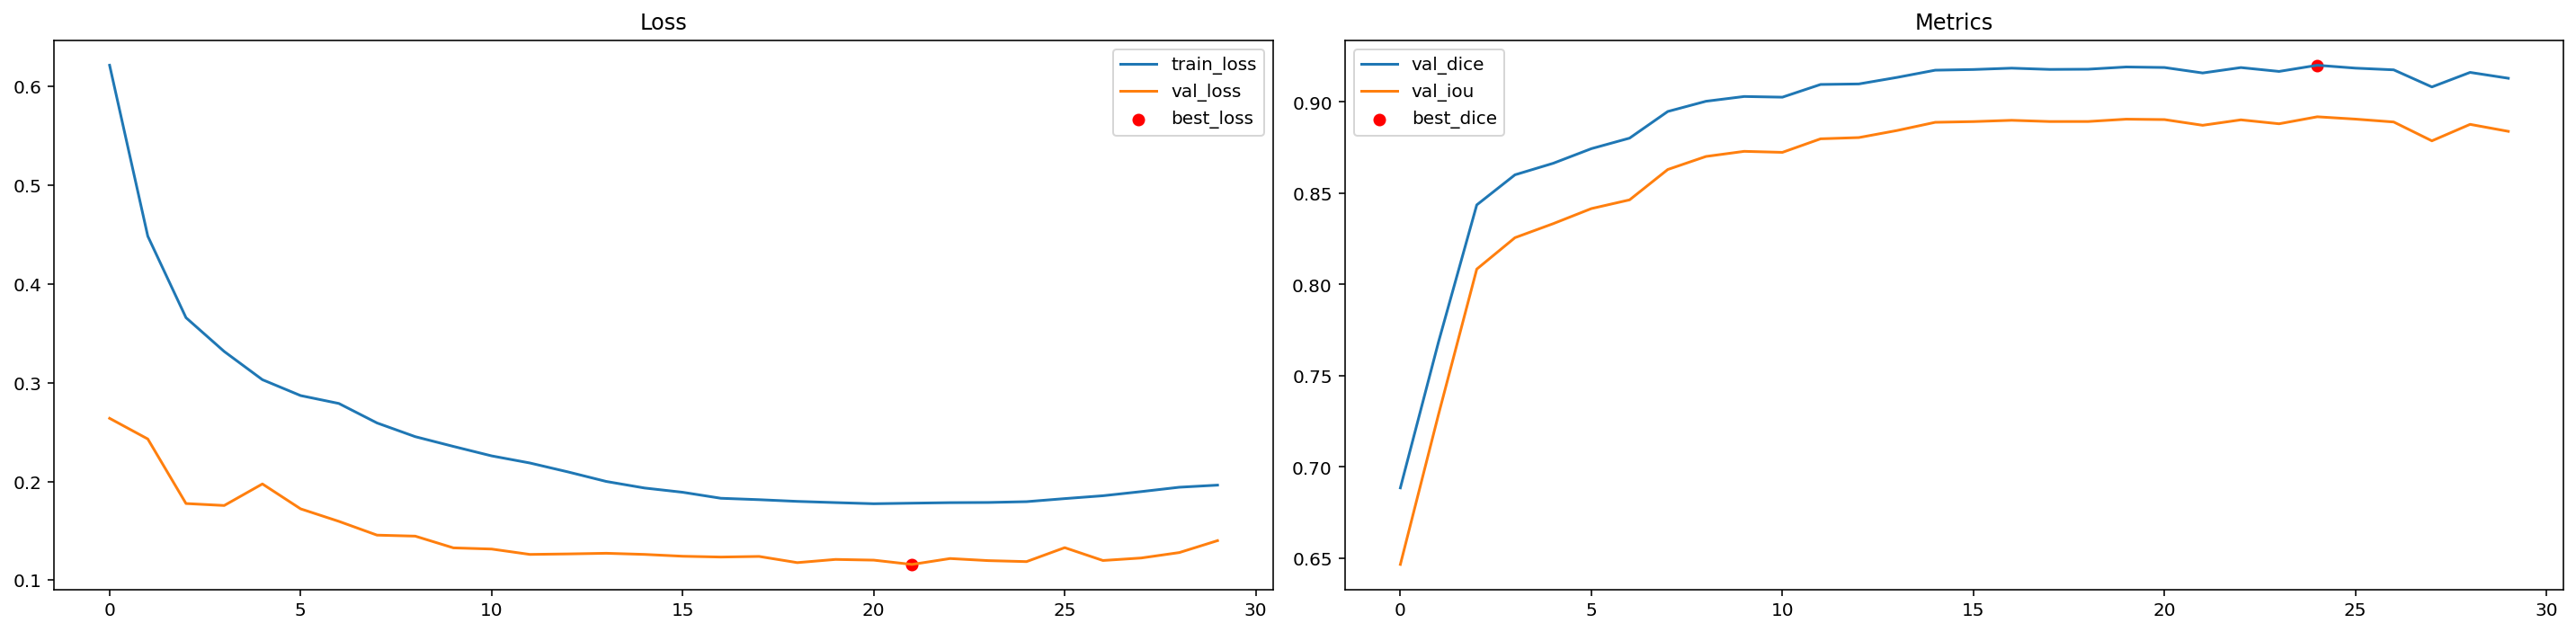

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(
    history["train_loss"],
    label="train_loss",
)
plt.plot(history["val_loss"], label="val_loss")
plt.scatter(
    history["best_loss_epoch"], history["best_loss"], color="r", label="best_loss"
)
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Metrics")
plt.plot(history["val_dice"], label="val_dice")
plt.plot(history["val_iou"], label="val_iou")
plt.scatter(
    history["best_dice_epoch"], history["best_dice"], color="r", label="best_dice"
)
plt.legend()
plt.tight_layout()
plt.show();

In [38]:
model.load_state_dict(best_weights["loss"])

<All keys matched successfully>

In [20]:
test_ds = Dataset(
    df=df[(df["fold"] == CONFIG["FOLD"]) & (df["is_mask"])],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col=col,
    norm=CONFIG["NORMALIZE"],
    shuffle=False,
    seed=CONFIG["SEED"],
    transform=None,
    pad=False,
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=20, shuffle=False, num_workers=0
)

In [21]:
imgs, masks = next(iter(test_loader))

In [22]:
model = model.eval()
with torch.no_grad():
    predictions = torch.nn.Sigmoid()(model(imgs.to("cuda"))).detach().cpu().numpy()

imgs = imgs.detach().cpu().numpy()
masks = masks.detach().cpu().numpy()

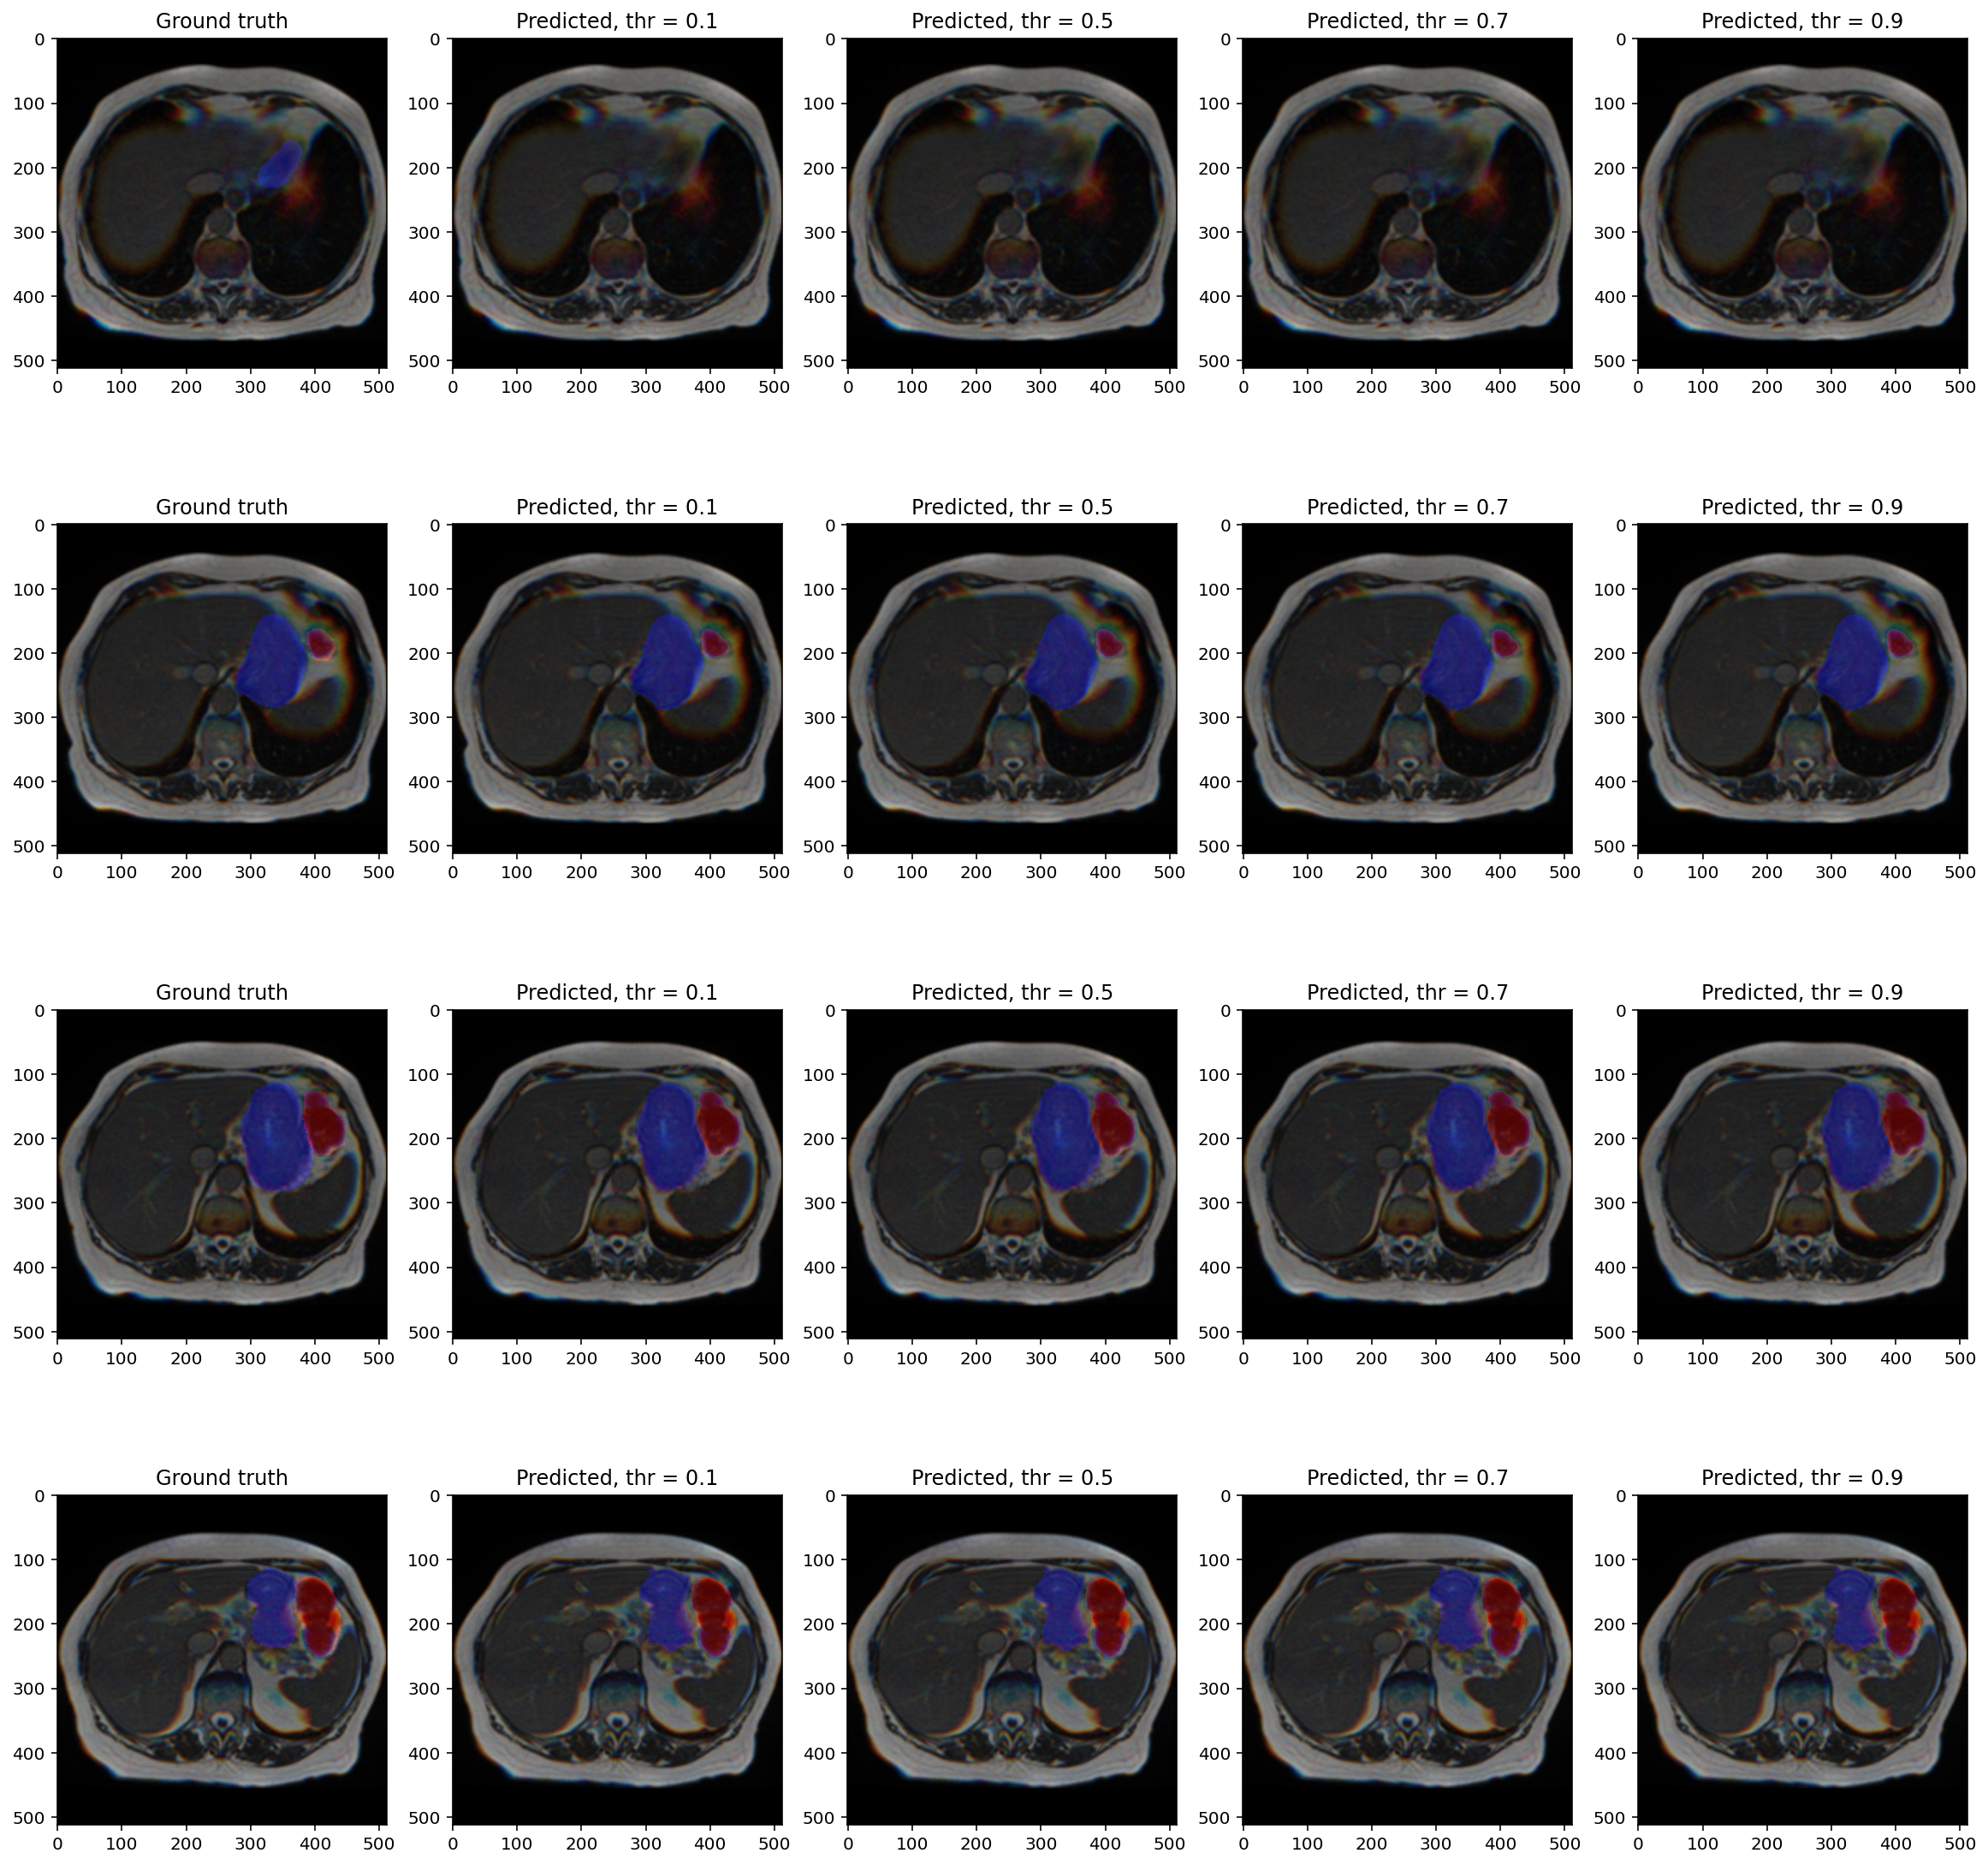

In [23]:
thr = [0.1, 0.5, 0.7, 0.9]

plt.figure(figsize=(20, 20))
for i in range(0, 20, 5):
    pred = predictions[i]
    mask = masks[i]
    img = imgs[i]
    plt.subplot(4, 5, i + 1)
    plt.title("Ground truth")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis(mask.astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 2)
    plt.title(f"Predicted, thr = {thr[0]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[0]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 3)
    plt.title(f"Predicted, thr = {thr[1]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[1]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 4)
    plt.title(f"Predicted, thr = {thr[2]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[2]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 5)
    plt.title(f"Predicted, thr = {thr[3]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[3]).astype("float32"), 0, 2), alpha=0.3)
plt.show();

In [24]:
CONFIG["MODEL_PATH"]

'/app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/'

In [25]:
with open(os.path.join(CONFIG["MODEL_PATH"], "config.json"), "w") as f:
    json.dump(CONFIG, f)

In [26]:
!kaggle datasets init -p {CONFIG["MODEL_PATH"]}

Data package template written to: /app/_data/models/deeplab_fold_5_two_sided_512_seed_42_seq_1/dataset-metadata.json


In [27]:
with open(os.path.join(CONFIG["MODEL_PATH"], "dataset-metadata.json"), "r") as f:
    meta = json.load(f)

In [28]:
name = f"deeplab-fold{CONFIG['FOLD']}-s{CONFIG['SEED']}-512-seq1"
meta["title"] = name
meta["id"] = f"nataliayurasova/{name}"

In [29]:
meta

{'title': 'deeplab-fold5-s42-512-seq1',
 'id': 'nataliayurasova/deeplab-fold5-s42-512-seq1',
 'licenses': [{'name': 'CC0-1.0'}]}

In [30]:
with open(os.path.join(CONFIG["MODEL_PATH"], "dataset-metadata.json"), "w") as f:
    json.dump(meta, f)

In [31]:
!kaggle datasets create -p {CONFIG["MODEL_PATH"]} -r zip

Starting upload for file weights.zip
100%|█████████████████████████████████████████| 289M/289M [05:16<00:00, 959kB/s]
Upload successful: weights.zip (289MB)
Starting upload for file history.json
100%|████████████████████████████████████████| 3.12k/3.12k [00:03<00:00, 906B/s]
Upload successful: history.json (3KB)
Starting upload for file config.json
100%|████████████████████████████████████████████| 577/577 [00:03<00:00, 186B/s]
Upload successful: config.json (577B)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/nataliayurasova/deeplab-fold5-s42-512-seq1
